In [1]:
# install.packages("tidyr")
# install.packages("sp")
# install.packages("rgdal")
# install.packages("rgeos")
# install.packages("ggmap")
# install.packages("tmap")
# install.packages("raster")
# install.packages("spdep")
# install.packages("gstat")
# install.packages("spgwr")
# install.packages("GWmodel")
# install.packages("ggplot2")
# install.packages("geojsonio")
# install.packages("broom")
# install.packages("gridExtra")

library(dplyr)
library(tidyr)
library(stringr)
library(sp)
library(rgdal)
library(rgeos)
library(tmap)
library(raster)
library(spdep)
library(gstat)
library(spgwr)
library(GWmodel)
library(ggplot2)
library(geojsonio)
library(broom)
library(gridExtra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


rgdal: version: 1.5-16, (SVN revision 1050)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.1.2, released 2020/07/07
Path to GDAL shared files: /usr/local/gdal-3.1.2/share/gdal
GDAL binary built with GEOS: FALSE 
Loaded PROJ runtime: Rel. 6.1.0, May 15th, 2019, [PJ_VERSION: 610]
Path to PROJ shared files: /usr/local/proj-6.1.0/share/proj
Linking to sp version:1.4-2
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.

rgeos version: 0.5-3, (SVN revision 634)
 GEOS runtime version: 3.8.0-CAPI-1.13.1 
 Linking to sp version: 1.4-2 
 Polygon checking: TRUE 



Attaching package: ‘raster’


The following object is masked from ‘package:tidyr’:

    ext

## 사고건수 및 사상자수를 포함한 유의미한 교통격자와 전체 교통격자 데이터 불러오기

In [2]:
accident_count <- read.csv('accident_count.csv', row.names = 1) # 유의미한 교통격자 데이터
dim(accident_count)
accident_count %>% head(2)

[1] 11870     7

,gid,acci_cnt,geometry,사고건수,사상자수,x,y
,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,다바866110,0,"MULTIPOLYGON (((127.3507618774412 36.2962226528149, 127.35076016019 36.29712419940831, 127.3518738869674 36.29712558434352, 127.3518755914034 36.29622403770472, 127.3507618774412 36.2962226528149)))",0,0,127.3513,36.29667
1,다바823157,0,"MULTIPOLYGON (((127.3027655376963 36.33852572474733, 127.3027632646547 36.33942726265638, 127.3038775905834 36.33942909649135, 127.3038798507832 36.33852755852221, 127.3027655376963 36.33852572474733)))",0,0,127.3033,36.33898


In [3]:
accident_grid <- read.csv('accident_grid.csv', row.names = 1) # 위도, 경도를 추가한 대전시 전체 교통격자 데이터
dim(accident_grid)
accident_grid %>% head(2)

[1] 54912     4

,gid,acci_cnt,x,y
,<fct>,<int>,<dbl>,<dbl>
0,다바866110,0,127.3513,36.29667
1,다바823157,0,127.3033,36.33898


## 4. '국지적 모란지수'를 통해 사고건수가 0인 값 중 의미없는 값을 제거

국지적 모란지수(Local Moran's)는 **인접지역 간 속성 값의 수치적 유사성을 근거로 양의 방향으로 공간적 상관이 형성되는 것을 확인하는 통계량**이다. <br/>
이를 통해 특정 지역들이 전체 지역의 공간적 자기 상관성에 얼마나 영향을 미치는지 확인 가능하다.

In [4]:
# 중심점으로부터 1.5km 반경의 이웃을 고려하여 이웃통계량을 계산, longlat=TRUE는 큰 원 거리를 계산하고 거리 단위로 킬로미터를 반환
S.dist <- spdep::dnearneigh(cbind(accident_count$x, accident_count$y), 0, 1.5, longlat=TRUE)
S.dist

Neighbour list object:
Number of regions: 11870 
Number of nonzero links: 3174290 
Percentage nonzero weights: 2.252917 
Average number of links: 267.4212 

[1] FALSE

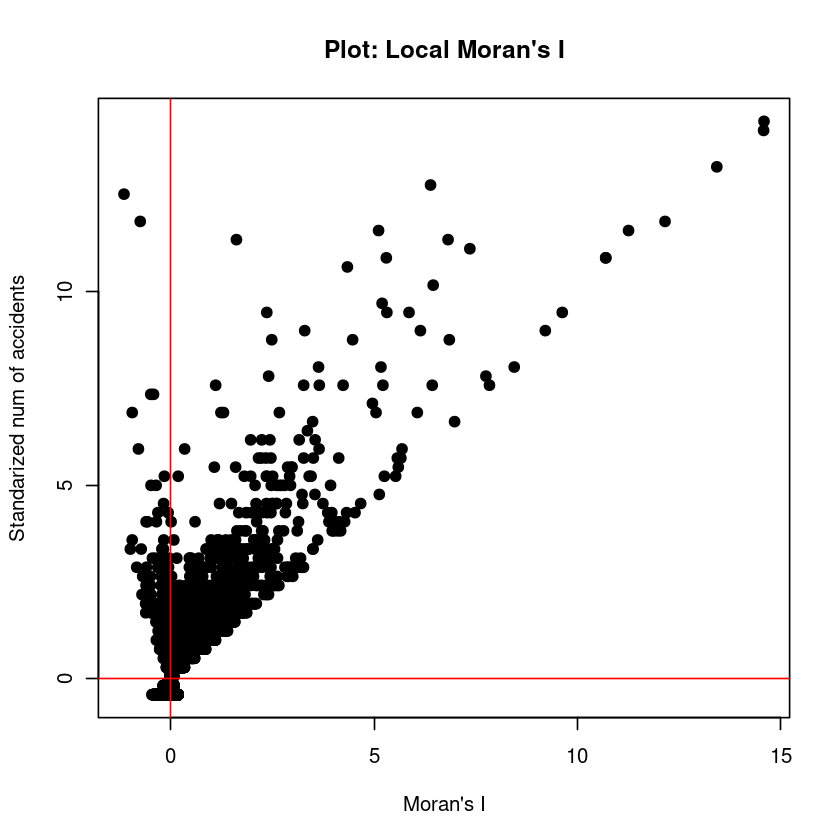

In [5]:
spdep::set.ZeroPolicyOption(TRUE)
lw <- spdep::nb2listw(S.dist, style="W", zero.policy=TRUE)
lom <- spdep::localmoran(accident_count$`사고건수`, lw, zero.policy=TRUE)
pr <- data.frame(cbind(lom[,1], (accident_count$`사고건수` - mean(accident_count$`사고건수`)) / sd(accident_count$`사고건수`)))
plot(pr, xlab="Moran's I", ylab="Standarized num of accidents", pch=19)
abline(h=0, col="red")
abline(v=0, col="red")
title("Plot: Local Moran's I")

- 1사분면: 이웃 지역과 특성 및 속성이 유사하면서 사고가 평균보다 많이 발생하는 지역
- 2사분면: 이웃 지역과 특성 및 속성이 유사하지는 않지만, 사고가 평균보다 많이 발생하는 지역
- 3사분면: 이웃 지역과 특성 및 속성이 유사하지 않으면서 사고가 평균보다 적게 발생하는 지역
- 4사분면: 이웃 지역과 특성 및 속성이 유사하지만, 사고가 평균보다 적게 발생하는 지역

여기서 제 4사분면에 있는 점들을 버리는(drop) 방법으로 진행하도록 한다.<br/>
그 이유는 이 구역의 사고건수의 Moran 통계량은 양의 값으로 특정 지역과 그 이웃 지역이 유사한 경향성을 갖지만 표준화된 사고 건수는 평균보다 낮은 경우로, <br/>
사고건수가 0 또는 작은 관측치들이 이 구역에 유사한 경향성(군집)을 가지고 있으면서 위치해 있을 것이라고 기대한다.

In [6]:
# 4사분면 부분이 아닌 부분을 필터링하여 최종 데이터 도출
pr_new <- pr[which(!pr$X1>0 | !pr$X2<0),]
accident_count_filter <- accident_count[as.numeric(rownames(pr_new)), ]

In [7]:
nrow(accident_count_filter)
table(accident_count_filter$`사고건수`) # 총 5556개

[1] 5556


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
1591  829  904  549  388  250  181  133  122  112   71   61   49   40   39   34 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
  30   19   14   11   15   13    3   10   12    6    9    4    5    1    2    6 
  32   33   34   35   36   39   40   42   43   45   47   48   49   50   51   52 
   1    2    7    2    3    3    3    4    1    1    1    3    1    2    2    2 
  55   56   58   62   63 
   1    1    1    1    1 

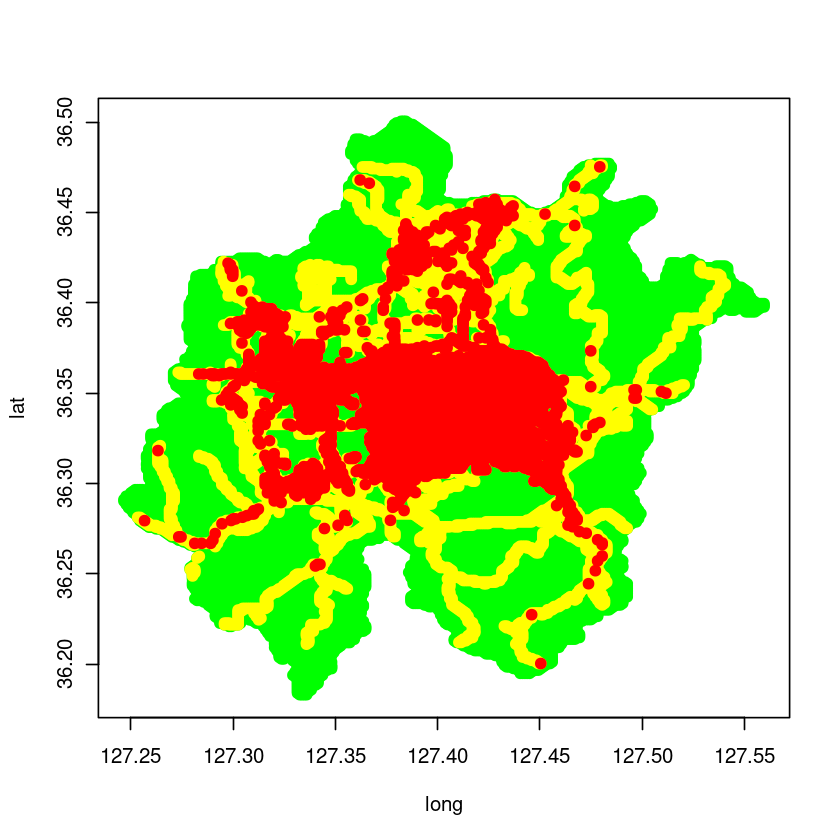

In [8]:
# 빨간색 지역이 사용할 수 있는 유의미한 데이터
plot(accident_grid$x, accident_grid$y, col="green", pch=19, xlab="long", ylab="lat")
lines(accident_count$x, accident_count$y, col="yellow", type="p", pch=19)
lines(accident_count_filter$x, accident_count_filter$y, col = "red", type="p", pch=19)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
5369  945  904  549  388  250  181  133  122  112   71   61   49   40   39   34 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
  30   19   14   11   15   13    3   10   12    6    9    4    5    1    2    6 
  32   33   34   35   36   39   40   42   43   45   47   48   49   50   51   52 
   1    2    7    2    3    3    3    4    1    1    1    3    1    2    2    2 
  55   56   58   62   63 
   1    1    1    1    1 

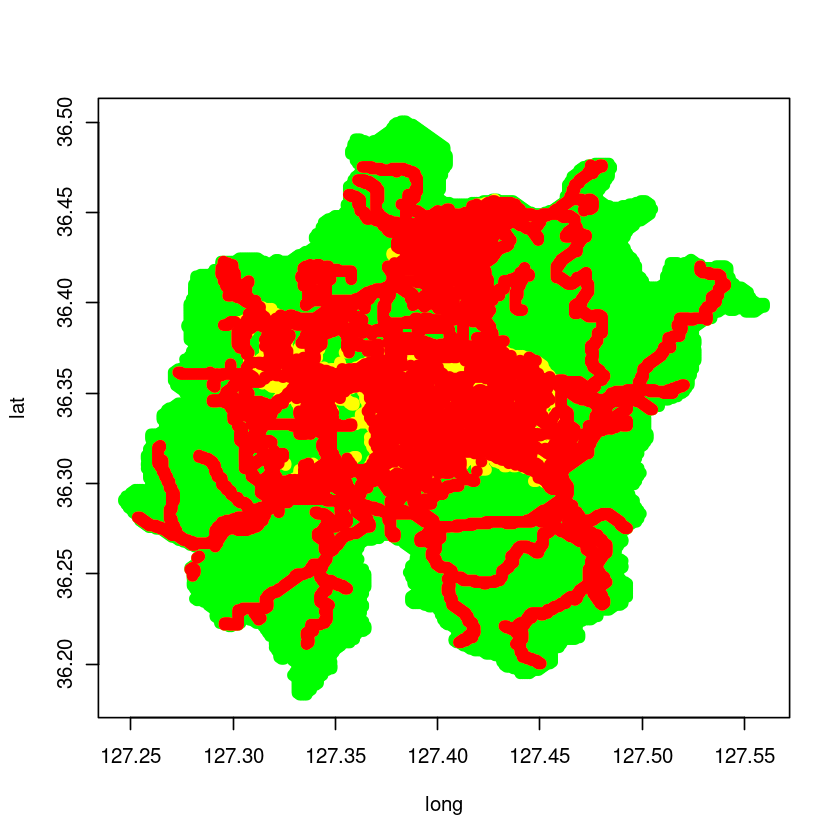

In [9]:
# 대조하기 위하여 4사분면이 아닌 3사분면을 기준으로 필터링한 데이터
pr_new2 <- pr[which(pr$X1>0 | pr$X2>0), ]
accident_count_filter_2 <- accident_count[as.numeric(rownames(pr_new2)), ]
plot(accident_grid$x, accident_grid$y, col="green", pch=19, xlab="long", ylab="lat")
lines(accident_count$x, accident_count$y, col="yellow", type="p", pch=19)
lines(accident_count_filter_2$x, accident_count_filter_2$y, col = "red", type="p", pch=19)
table(accident_count_filter_2$`사고건수`)

In [10]:
table(accident_count$acci_cnt == 0) # 전체 데이터에서 0의 개수는 6959개로 절반 이상

except_4quadrant <- pr[which(!pr$X1 > 0 | !pr$X2 < 0),]
except_4quadrant_df <- accident_count[as.numeric(rownames(except_4quadrant)), ]
table(except_4quadrant_df$acci_cnt == 0) # 4사분면을 제외한 데이터에서 0의 개수는 1590개

except_3quadrant <- pr[which(!pr$X1 < 0 | !pr$X2 < 0),]
except_3quadrant_df <- accident_count[as.numeric(rownames(except_3quadrant)), ]
table(except_3quadrant_df$acci_cnt == 0) # 3사분면을 제외한 데이터에서 0의 개수는 5369개


FALSE  TRUE 
 4911  6959 


FALSE  TRUE 
 3966  1590 


FALSE  TRUE 
 4081  5369 

위의 설명과 다르게 4사분면이 아닌 3사분면을 필터링하는 경우에는 위 그림과 같은 결과를 확인할 수 있다.<br/>
4사분면을 필터링한 경우에는 0의 개수가 1,591개인 반면, 3사분면을 필터링한 경우에는 5,369개로 여전히 불균형 데이터 문제가 해결되지 않았다.<br/>
또한 사고건수가 0인 격자들이 많은 변두리나 산간 지역도 많이 남아 있는 것을 확인할 수 있다.<br/>
따라서 기존 논리에 맞게 4사분면 지역을 필터링한 데이터가 가장 유의미한 것을 다시 확인할 수 있었다. <br/>

In [11]:
rownames(accident_count_filter) <- NULL # reset_index
dim(accident_count_filter)
accident_count_filter %>% head(2)

[1] 5556    7

,gid,acci_cnt,geometry,사고건수,사상자수,x,y
,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,다바931203,2,"MULTIPOLYGON (((127.4230710131166 36.38013455218083, 127.4230701251944 36.38103608833949, 127.4241850500282 36.38103680113275, 127.424185925082 36.38013526495075, 127.4230710131166 36.38013455218083)))",2,2,127.4236,36.38059
2,다바861174,0,"MULTIPOLYGON (((127.3450791441312 36.35391426501025, 127.3450773577309 36.35481580264442, 127.3461919054753 36.3548172424657, 127.346193679024 36.35391570478436, 127.3450791441312 36.35391426501025)))",0,0,127.3456,36.35437


이를 통해 **기존의 54,912개의 격자를 최종적으로 5,556개의 고유한 격자 데이터**로 필터링했다.<br/>
이렇게 추려진 데이터를 다시 한번 시각화를 통해서 직관적으로 확인하도록 한다.

In [12]:
daejeon <- geojson_read('27.대전광역시_행정경계(읍면동).geojson', what='sp')
daejeon_tidy <- tidy(daejeon)

Regions defined for each Polygons



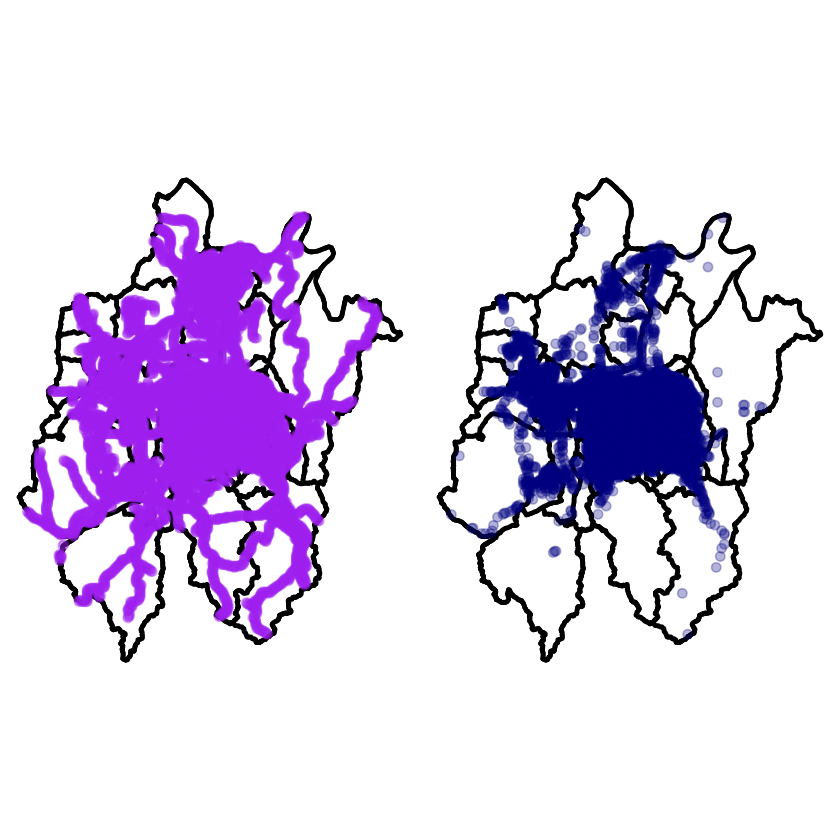

In [13]:
road_filter_map <- 
    ggplot() + geom_polygon(data=daejeon_tidy, aes(x=long, y =lat, group=group), fill='white', color='black', size=1) +
    coord_map() + theme_void() + geom_point(data = accident_count,aes(x= x, y= y),color= 'purple',size=2,, alpha=0.3)+
    scale_color_gradient(high='red', low='skyblue', guide_legend(title="Coefs for PSC_cnt"))

moran_filter_map <- 
    ggplot() + geom_polygon(data=daejeon_tidy, aes(x=long, y =lat, group=group), fill='white', color='black', size=1) +
    coord_map() + theme_void() + geom_point(data = accident_count_filter,aes(x= x, y= y),color= 'navy',size=2,, alpha=0.3)+
    scale_color_gradient(high='red', low='skyblue', guide_legend(title="Coefs for PSC_cnt"))

grid.arrange(road_filter_map, moran_filter_map,nrow = 1, ncol = 2)

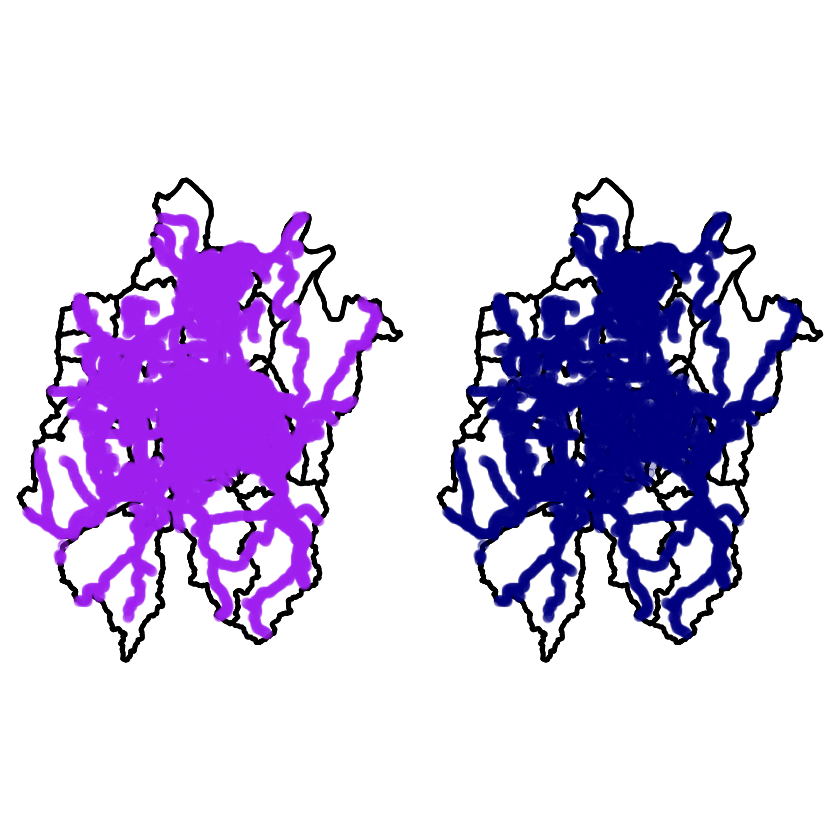

In [14]:
road_filter_map2 <- 
    ggplot() + geom_polygon(data=daejeon_tidy, aes(x=long, y =lat, group=group), fill='white', color='black', size=1) +
    coord_map() + theme_void() + geom_point(data = accident_count,aes(x= x, y= y),color= 'purple',size=2,, alpha=0.3)+
    scale_color_gradient(high='red', low='skyblue', guide_legend(title="Coefs for PSC_cnt"))

moran_filter_map2 <- 
    ggplot() + geom_polygon(data=daejeon_tidy, aes(x=long, y =lat, group=group), fill='white', color='black', size=1) +
    coord_map() + theme_void() + geom_point(data = accident_count_filter_2,aes(x= x, y= y),color= 'navy',size=2,, alpha=0.3)+
    scale_color_gradient(high='red', low='skyblue', guide_legend(title="Coefs for PSC_cnt"))

grid.arrange(road_filter_map2, moran_filter_map2, nrow = 1, ncol = 2)

In [15]:
write.csv(accident_count_filter, file='accident_count_filter.csv', row.names=F)